# Searching for Structure in Point Data

We will address methods for exploring
and quantifying structure in a multivariate distribution of points. One name
for this kind of activity is exploratory data analysis (EDA). Given a sample of
N points in D-dimensional space, there are three classes of problems that are
frequently encountered in practice: density estimation, cluster finding, and statistical
description of the observed structure. The space populated by points in the sample
can be real physical space, or a space spanned by the measured quantities (attributes).

For example, we can consider the distribution of sources in a multidimensional color space, or in a six-dimensional space spanned by three-dimensional positions and three-dimensional velocities.
To infer the pdf from a sample of data is known as density estimation. The same methodology is often called data smoothing.

Density estimation is one of the most critical components of extracting knowledge from
data. For example, given a pdf estimated from point data, we can generate simulated
distributions of data and compare them against observations. If we can identify
regions of low probability within the pdf, we have a mechanism for the detection
of unusual or anomalous sources. If our point data can be separated into subsamples
using provided class labels, we can estimate the pdf for each subsample and use the
resulting set of pdfs to classify new points: the probability that a new point belongs to
each subsample/class is proportional to the pdf of each class evaluated at the position
of the point.

Given a point data set, we can further ask whether it displays any structure (as
opposed to a random distribution of points). Finding concentrations of multivariate
points (or groups of sources) is known in astronomy as “clustering” (when a density
estimate is available, clusters correspond to “overdensities”). Clusters can be defined o be distinct objects (e.g., gravitationally bound clusters of galaxies), or loose groups
of sources with common properties (e.g., the identification of quasars based on
their color properties).

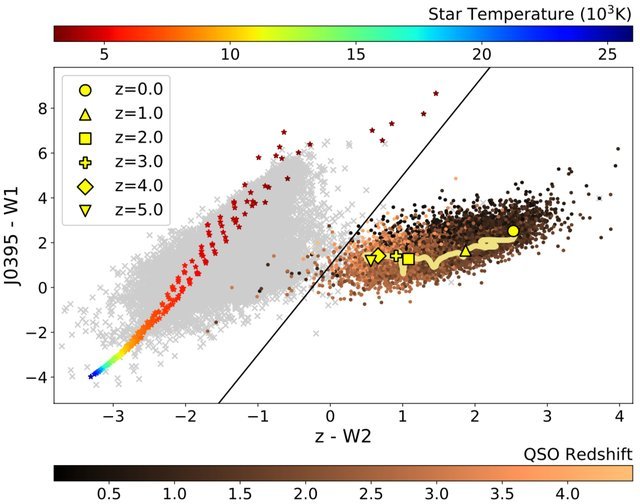

Unsupervised clustering refers to cases where there is no prior information about the number and properties of clusters in data. Unsupervised
classification, discussed in chapter 9, assigns to each cluster found by unsupervised
clustering, a class based on additional information (e.g., clusters identified in color
space might be assigned the labels “quasar” and “star” based on supplemental spectral
data).


In some cases, such as when considering the distribution of sources in multi-
dimensional color space, clusters can have specific physical meaning (e.g., hot stars,
quasars, cold stars). On the other hand, in some applications, such as large-scale
clustering of galaxies, clusters carry information only in a statistical sense. For example, we can test cosmological models of structure formation by comparing clustering
statistics in observed and simulated data. Correlation functions are commonly used
in astronomy for the statistical description of clustering.

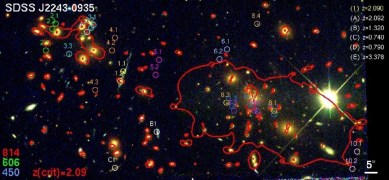

# Nonparametric Density Estimation
We now look at how to estimate a
density nonparametrically, that is, without specifying a specific functional model.

Real data rarely follow simple distributions—nonparametric methods are meant to
capture every aspect of the density’s shape. What we lose by taking this route is the
convenience, relative computational simplicity (usually), and easy interpretability of
parametric models.

The go-to method for nonparametric density estimation, that is, modeling of the underlying distribution, is the method of kernel density estimation (KDE).

While a very simple method in principle, it also comes with impressive theoretical
properties.

# Kernel Density Estimation
As a motivation for kernel density estimation, let us first reconsider the one-
dimensional histograms. One problem with a standard histogram is the fact that the exact locations of the bins can make a difference, and yet it is not clear how to choose in advance where the bins should be placed. We
illustrate this problem in the two top panels in next figure. They show histograms
constructed with an identical data set, and with identical bin widths, but with
bins offset in x by 0.25. This offset leads to very different histograms and possible
interpretations of the data: the difference between seeing it as a bimodal distribution
vs. an extended flat distribution.

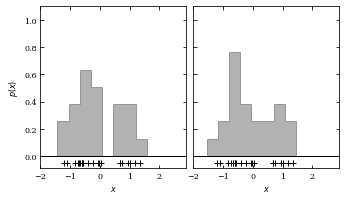

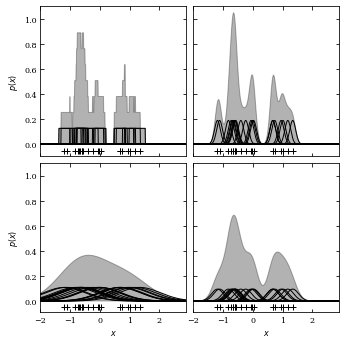

In [ ]:
"""
Histogram vs Kernel Density Estimation
--------------------------------------
Figure 6.1
Density estimation using histograms and kernels. The top panels show two
histogram representations of the same data (shown by plus signs in the bottom
of each panel) using the same bin width, but with the bin centers of the
histograms offset by 0.25. The middle-left panel shows an adaptive histogram
where each bin is centered on an individual point and these bins can overlap.
This adaptive representation preserves the bimodality of the data. The
remaining panels show kernel density estimation using Gaussian kernels with
different bandwidths, increasing from the middle-right panel to the
bottom-right, and with the largest bandwidth in the bottom-left panel. The
trade-off of variance for bias becomes apparent as the bandwidth of the
kernels increases.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Draw the random data
np.random.seed(1)
x = np.concatenate([np.random.normal(-0.5, 0.3, size=14),
                    np.random.normal(1, 0.3, size=7)])


#------------------------------------------------------------
# First figure: silly histogram binning
fig1 = plt.figure(figsize=(5, 3))
fig1.subplots_adjust(left=0.12, right=0.95, wspace=0.05,
                     bottom=0.15, top=0.9, hspace=0.05)

FC = '#6666FF'
XLIM = (-2, 2.9)
YLIM = (-0.09, 1.1)

ax = fig1.add_subplot(121)
bins = np.linspace(-1.8, 2.7, 13)
ax.hist(x, bins=bins, density=True,
        histtype='stepfilled', fc='k', alpha=0.3)
ax.plot(XLIM, [0, 0], '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

ax = fig1.add_subplot(122)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.hist(x, bins=bins + 0.25, density=True,
        histtype='stepfilled', fc='k', alpha=0.3)
ax.plot(XLIM, [0, 0], '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')

#------------------------------------------------------------
# First figure: transition to KDE
fig2 = plt.figure(figsize=(5, 5))
fig2.subplots_adjust(left=0.12, right=0.95, wspace=0.05,
                     bottom=0.1, top=0.95, hspace=0.05)

ax = fig2.add_subplot(221)
ax.xaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = (abs(x_plot - x[:, None]) <= 0.5 * binwidth).astype(float)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_ylabel('$p(x)$')

ax = fig2.add_subplot(222)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], 0.1)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)

ax = fig2.add_subplot(223)
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], 0.7)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, 4 * y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_ylabel('$p(x)$')
ax.set_xlabel('$x$')

ax = fig2.add_subplot(224)
ax.yaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], 0.2)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')

plt.show()


Given a set of measurements {$x_i$}, the kernel density estimator (i.e., an estimator
of the underlying pdf) at an arbitrary position x is defined as:

$$f_N(x)=\frac{1}{Nh^D}\sum_{i=1}^{N}K(\frac{d(x, x_i)}{h})$$

where $K(u)$ is the kernel function and $h$ is known as the bandwidth (which defines
the size of the kernel). The local density is estimated as a weighted mean of all points,
where the weights are specified via $K(u)$ and typically decrease with distance $d(x, x_i)$.
Alternatively, KDE can be viewed as replacing each point with a “cloud” described
by $K(u)$. The kernel function $K(u)$ can be any smooth function that is positive at all points ($K (u) ≥ 0$), normalizes to unity ($\int K(u) du = 1$), has a mean of zero $\int u K(u)du = 0$), and has a variance ($\sigma_K^2 = \int u^2 K (u) du$) greater than zero. An
often-used kernel is the Gaussian kernel:

$$K(u)=\frac{1}{(2\pi)^{D/2}}\exp^{(-u^2/2)}$$

where $D$ is the number of dimensions of the parameter space and $u = d(x, x_i)/ h$.
Other kernels that can be useful are the top-hat (box) kernel,

$$K(u)=\frac{1}{V_D(1)}, u \leq 1$$

and the exponential kernel,

$$K(u)=\frac{1}{D!V_D(1)}e^{-|u|}$$

where $V_D(r)$ is the volume of a D-dimensional hypersphere of radius r.
A comparison of the Gaussian, exponential, and top-hat kernels is shown next:

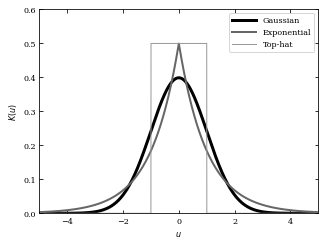

In [ ]:

"""
Example Kernels
---------------
Figure 6.2
A comparison of the three kernels used for density estimation in figure 6.3:
the Gaussian kernel (eq. 6.2), the top-hat kernel (eq. 6.3), and the
exponential kernel (eq. 6.4).
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Compute Kernels.
x = np.linspace(-5, 5, 10000)
dx = x[1] - x[0]

gauss = (1. / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x ** 2)

exp = 0.5 * np.exp(-abs(x))

tophat = 0.5 * np.ones_like(x)
tophat[abs(x) > 1] = 0

#------------------------------------------------------------
# Plot the kernels
fig = plt.figure(figsize=(5, 3.75))
ax = fig.add_subplot(111)

ax.plot(x, gauss, '-', c='black', lw=3, label='Gaussian')
ax.plot(x, exp, '-', c='#666666', lw=2, label='Exponential')
ax.plot(x, tophat, '-', c='#999999', lw=1, label='Top-hat')

ax.legend(loc=1)

ax.set_xlabel('$u$')
ax.set_ylabel('$K(u)$')

ax.set_xlim(-5, 5)
ax.set_ylim(0, 0.6001)
plt.show()

# Selecting the KDE bandwidth using cross-validation
Both histograms and KDE do, in fact, have a parameter: the kernel or bin width. The
proper choice of this parameter is critical, much more so than the choice of a specific
kernel, particularly when the data set is large. We will now show a rigorous procedure for choosing the optimal kernel width in KDE (which can also be applied to finding the optimal bin width for a histogram).

Cross-validation can be used for any cost function; we just have to be able to evaluate the cost on out-of-sample data (i.e., points not in the training set). If we consider the likelihood cost for KDE, for which we have the leave-one-out likelihood cross-validation, then the cost is simply the sum over all points in the data set (i.e., i = 1, . . . , N) of the log of the likelihood of the density, where the density $f_{h,−i}(x_i)$, is estimated leaving out the i-th data point. This can be written as

$$CV_l(h)=\frac{1}{N}\sum_{i=1}^{N}log(f_{h,-i}(x_i))$$

and, by minimizing $CV_l(h)$ as a function of bandwidth, we can optimize for the width
of the kernel h.

An alternative to likelihood cross-validation is to use the mean integrated square error (MISE), $MISE=\int_{-\infty}^{\infty}[f(x)-h(x)]^2 dx$, as the cost function. To determine the value of $h$ that minimizes the MISE we can write

$$\int(f_h-f)^2=\int f_h^2 -2\int f_h f+\int f^2$$

This motivates the $L_2$ cross-validation score:

$$CV_{L_2}(h)=\int f_h^2-2\frac{1}{N}\sum_{i=1}^{N}f_{h, -i}(x)$$

The optimal KDE bandwidth decreases at the rate $O(N^−1/5)$ (in a one-dimensional problem), and the error of the KDE using the optimal bandwidth
converges at the rate $O(N^{−4/5})$; it can be shown that histograms converge at a rate
$O(N^{−2/3}$). KDE is, therefore, theoretically superior to the histogram as an
estimator of the density. It can also be shown that there does not exist a density estimator that converges faster than $O(N^{−4/5})$.

Ideally we would select a kernel that has $h$ as small as possible. If $h$ becomes too
small we increase the variance of the density estimation. If $h$ is too large then the
variance decreases but at the expense of the bias in the derived density. The optimal
kernel function, in terms of minimum variance, turns out to be

$$K(x)=\frac{3}{4}(1-x^2)$$,

for $|x| \leq 1$. This function is called the Epanechnikov kernel. AstroML contains an implementation of kernel density estimation in D
dimensions using the above kernels:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


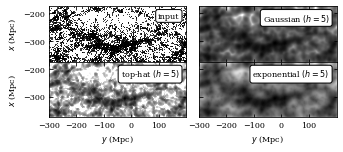

In [ ]:

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.neighbors import KernelDensity

from astroML.datasets import fetch_great_wall

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

kernels = ['gaussian', 'tophat', 'exponential']
dens = []

kde1 = KernelDensity(bandwidth=5, kernel='gaussian')
log_dens1 = kde1.fit(X).score_samples(Xgrid)
dens1 = X.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))

kde2 = KernelDensity(bandwidth=5, kernel='tophat')
log_dens2 = kde2.fit(X).score_samples(Xgrid)
dens2 = X.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))

kde3 = KernelDensity(bandwidth=5, kernel='exponential')
log_dens3 = kde3.fit(X).score_samples(Xgrid)
dens3 = X.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 2.2))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens1.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "Gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: top-hat kernel
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens2.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "top-hat $(h=5)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax3.images[0].set_clim(0.01, 0.8)

# Fourth plot: exponential kernel
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens3.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "exponential $(h=5)$", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

# KDE with Measurement Errors
Suppose now that the points (i.e., their coordinates) are measured with some error $\sigma$. We begin with the simple one-dimensional case with homoscedastic errors. Assume that the data is drawn from the true pdf $h(x)$, and the error is described by the
distribution $g(x|\sigma)$. Then the observed distribution $f(x)$ is given by the convolution:

$$f(x)=(h \star g)(x)=\int_{-\infty}^{\infty} h(x')g(x-x')dx'$$

This suggests that in order to obtain the underlying noise-free density $h(x)$, we
can obtain an estimate $f(x)$ from the noisy data first, and then “deconvolve” the
noise pdf. The nonparametric method of $deconvolution KDE$ does precisely this. According to the convolution theorem, a convolution in real space corresponds to a product in Fourier space. Because of this,
deconvolution KDE can be computed using the following steps:

1. Find the kernel density estimate of the observed data, $f(x)$, and compute the
Fourier transform $F(k)$.

2. Compute the Fourier transform $G(k)$ of the noise distribution $g(x)$.

3. From the previousequation and the convolution theorem, the Fourier transform of the true
distribution $h(x)$ is given by $H(k) = F (k)/G (k)$. The underlying noise-free pdf $h(x)$ can be computed via the inverse Fourier transform of $H(k)$.

For certain kernels K (x) and certain noise distributions g (x), this deconvolution can
be performed analytically and the result becomes another modified kernel, called the
deconvolved kernel. an examples of kernel and noise forms which have these properties
can be found in https://arxiv.org/abs/astro-ph/9712287. Here we will describe one example of a D-dimensional version of this method, where the noise scale is assumed to be heteroscedastic and
dependent on the dimension. The noise model leads to an analytic treatment of the
deconvolved kernel. We will assume that the noise is distributed according to the
multivariate exponential.

$$g(x)=\frac{1}{\sqrt{2^D}\sigma_1\sigma_2...\sigma_D}exp(-\sqrt{2}(\frac{x_1}{\sigma_1}+\frac{x_2}{\sigma_2}+...+\frac{x_D}{\sigma_D}))$$

where the $\sigma_i$ represent the standard deviations in each dimension. We will assume
that $(\sigma_1, . . . ,\sigma_D)$ are known for each data point. For the case of a Gaussian kernel function, the deconvolution kernel is then

$$K_{h,\sigma}(x)=\frac{1}{\sqrt{(2\pi)^D}}exp(-|x|^2/2)\prod_{i}(1-\frac{\sigma_i^2}{2h^2}(x_i^2-1))$$

This deconvolution kernel can then be used in place of the kernels discussed above, noting the additional dependence on the error $\sigma_i$ of each point.

## Extensions and Related Methods
The idea of kernel density estimation can be extended to other tasks, including
classification (kernel discriminant analysis), regression (kernel regression), and conditional density estimation (kernel conditional density estimation). Some of the ideas that have been developed to make kernel regression highly
accurate, can be brought back to density estimation, including the idea of using variable bandwidths, in which each data point can have its own kernel width.

# Nearest-Neighbor Density Estimation
Another often used and simple density estimation technique is based on the distribution of nearest neighbors. For each point (e.g., a pixel location on the two-dimensional grid) we can find the distance to the K th-nearest neighbor, $d_K$. In this method, originally proposed in an astronomical context by Dressler et al. see https://iopscience.iop.org/article/10.1086/319405, the implied point density at an arbitrary position x is estimated as:

$$f_K(x)=\frac{K}{V_{D}(d_K)}$$

where the volume $V_D$ is evaluated according to the problem dimensionality, $D$ (e.g.,
for $D = 2, V_2 = \pi d^2$ ; for $D = 3, V_3 = 4\pi d^3 / 3$). The simplicity of this estimator is a consequence of the assumption that the
underlying density field is locally constant. In practice, the method is even simpler because one can compute

$$f_K(x)=\frac{C}{d_K^D}$$

and evaluate the scaling factor $C$ at the end by requiring that the sum of the product
of $f_K (x)$ and pixel volume is equal to the total number of data points. The error in
$f_K (x)$ is $\sigma_f = K^1/2 / V_D (d_K )$, and the fractional (relative) error is $\sigma_f /f = 1/K^{1/2}$.

Therefore, the fractional accuracy increases with K at the expense of the spatial
resolution (the effective resolution scales with $K^1/D$). In practice, K should be at
least 5 because the estimator is biased and has a large variance for smaller K.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


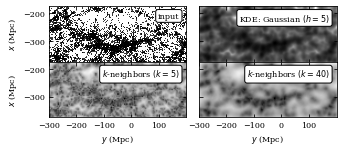

In [ ]:
"""
Great Wall Density
------------------
Figure 6.4
Density estimation for galaxies within the SDSS "Great Wall." The upper-left
panel shows points that are galaxies, projected by their spatial locations
onto the equatorial plane (declination ~ 0 degrees). The remaining panels
show estimates of the density of these points using kernel density estimation
(with a Gaussian kernel with width 5Mpc), a K-nearest-neighbor estimator
(eq. 6.15) optimized for a small-scale structure (with K = 5), and a
K-nearest-neighbor estimator optimized for a large-scale structure
(with K = 40).
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.neighbors import KernelDensity
from astroML.datasets import fetch_great_wall
from astroML.density_estimation import KNeighborsDensity

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

kde = KernelDensity(kernel='gaussian', bandwidth=5)
log_pdf_kde = kde.fit(X).score_samples(Xgrid).reshape((Ny, Nx))
dens_KDE = np.exp(log_pdf_kde)

knn5 = KNeighborsDensity('bayesian', 5)
dens_k5 = knn5.fit(X).eval(Xgrid).reshape((Ny, Nx))

knn40 = KNeighborsDensity('bayesian', 40)
dens_k40 = knn40.fit(X).eval(Xgrid).reshape((Ny, Nx))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 2.2))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: KDE
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens_KDE.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "KDE: Gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: KNN, k=5
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens_k5.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "$k$-neighbors $(k=5)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Fourth plot: KNN, k=40
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens_k40.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "$k$-neighbors $(k=40)$", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

Next figure compares Bayesian blocks, KDE, and nearest-neighbor density estimation for two one-dimensional data sets drawn from the same (relatively complicated) generating distribution. The generating distribution includes several “peaks” that are described
by the Cauchy distribution. KDE and nearest-neighbor methods are much
noisier than the Bayesian blocks method in the case of the smaller sample; for the
larger sample all three methods produce similar results.

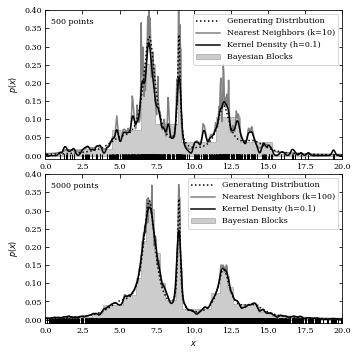

In [ ]:
"""
Comparison of 1D Density Estimators
-----------------------------------
Figure 6.5
A comparison of different density estimation methods for two simulated
one-dimensional data sets (cf. figure 5.21). The generating distribution is
same in both cases and shown as the dotted line; the samples include 500
(top panel) and 5000 (bottom panel) data points (illustrated by vertical bars
at the bottom of each panel). Density estimators are Bayesian blocks
(Section 5.7.2), KDE (Section 6.1.1) and the nearest-neighbor method (eq. 6.15).
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from sklearn.neighbors import KernelDensity

from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
#  this is the same data used in the Bayesian Blocks figure
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (500, 5000)
subplots = (211, 212)
k_values = (10, 100)

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)

    # Compute density with KDE
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(xN[:, None])
    dens_kde = np.exp(kde.score_samples(t[:, None]))

    # Compute density with Bayesian nearest neighbors
    nbrs = KNeighborsDensity('bayesian', n_neighbors=k).fit(xN[:, None])
    dens_nbrs = nbrs.eval(t[:, None]) / N

    # plot the results
    ax.plot(t, true_pdf(t), ':', color='black', zorder=3,
            label="Generating Distribution")
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')
    hist(xN, bins='blocks', ax=ax, density=True, zorder=1,
         histtype='stepfilled', color='k', alpha=0.2,
         label="Bayesian Blocks")
    ax.plot(t, dens_nbrs, '-', lw=1.5, color='gray', zorder=2,
            label="Nearest Neighbors (k=%i)" % k)
    ax.plot(t, dens_kde, '-', color='black', zorder=3,
            label="Kernel Density (h=0.1)")

    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right')

    if subplot == 212:
        ax.set_xlabel('$x$')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)

plt.show()

# How works a KNN search in a huge SQL database?

Think CDS Strasbourgh, SDSS Skyserver. Read the following article.

http://www.master-project-h2020.eu/wp-content/uploads/2018/10/SIGSPATIAL2018_Preprint_UVSQ.pdf

# Parametric Density Estimation
KDE estimates the density of a set of points by affixing a kernel to each point in the
data set. An alternative is to use fewer kernels, and fit for the kernel locations as well
as the widths. This is known as a mixture model, and can be viewed in two ways: at
one extreme, it is a density estimation model similar to KDE. In this case one is not
concerned with the locations of individual clusters, but the contribution of the full
set of clusters at any given point. At the other extreme, it is a clustering algorithm,
where the location and size of each component is assumed to reflect some underlying
property of the data.

## Gaussian Mixture Model
The most common mixture model uses Gaussian components, and is called a Gaussian mixture model (GMM). A GMM models the underlying density (pdf) of points as a sum of Gaussians. We have already encountered one-dimensional
mixtures of Gaussians; in this section we extend those results to multiple dimensions. Here the density of the points is given by

$$\rho(x)=Np(x)=N\sum_{j=1}^{N}\alpha_j N(\mu_j, \Sigma_j)$$

where the model consists of $M$ Gaussians with locations $\mu_j$ and covariances $\Sigma_j$.

 The likelihood of the data can be evaluated analogous to the 1D case. Thus there is not only
a clear score that is being optimized, the log-likelihood, but this is a special case where
that function is a generative model, that is, it is a full description of the data.

The optimization of this likelihood is more complicated in multiple dimensions
than in one dimension, but the expectation maximization methods EM previusly discussed  can be readily applied in this situation; see https://arxiv.org/abs/1105.1476. Here we will show an implementation of Gaussian mixture models for data sets in two dimensions, taken from real observations.


@pickle_results: computing results and saving to 'GMM_metallicity.pkl'
1
2
3
4
5
6
7
8
9
10
11
12
13
best fit converged: True
BIC: n_components =  5


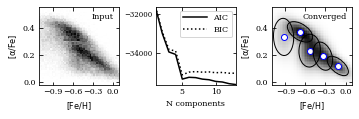

In [ ]:
"""
EM example: Gaussian Mixture Models
-----------------------------------
Figure 6.6
A two-dimensional mixture of Gaussians for the stellar metallicity data. The
left panel shows the number density of stars as a function of two measures of
their chemical composition: metallicity ([Fe/H]) and alpha-element abundance
([alpha/Fe]). The right panel shows the density estimated using mixtures of
Gaussians together with the positions and covariances (2-sigma levels) of
those Gaussians. The center panel compares the information criteria AIC
and BIC (see Sections 4.3.2 and 5.4.3).
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture

from astroML.datasets import fetch_sdss_sspp
from astroML.utils.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Get the Segue Stellar Parameters Pipeline data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute GaussianMixture models & AIC/BIC
N = np.arange(1, 14)


@pickle_results("GMM_metallicity.pkl")
def compute_GaussianMixture(N, covariance_type='full', max_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        print(N[i])
        models[i] = GaussianMixture(n_components=N[i], max_iter=max_iter,
                                    covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GaussianMixture(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

#------------------------------------------------------------
# compute 2D density
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(list(map(np.ravel,
                          np.meshgrid(0.5 * (FeH_bins[:-1]
                                             + FeH_bins[1:]),
                                      0.5 * (alphFe_bins[:-1]
                                             + alphFe_bins[1:]))))).T
log_dens = gmm_best.score_samples(Xgrid).reshape((51, 51))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 1.66))
fig.subplots_adjust(wspace=0.45,
                    bottom=0.25, top=0.9,
                    left=0.1, right=0.97)

# plot density
ax = fig.add_subplot(131)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.text(0.93, 0.93, "Input",
        va='top', ha='right', transform=ax.transAxes)

# plot AIC/BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(133)
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.text(0.93, 0.93, "Converged",
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

This is one of the common misunderstandings of Gaussian mixture models: the fact that the information criteria, such as BIC/AIC, prefer an N-component peak does not necessarily mean that there are N components. If the clusters in the
input data are not near Gaussian, or if there is a strong background, the number of Gaussian components in the mixture will not generally correspond to the number of clusters in the data. On the other hand, if the goal is to simply describe the underlying pdf, many more components than suggested by BIC can be (and should be) used.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


@pickle_results: computing results and saving to 'great_wall_GMM.pkl'
converged: True


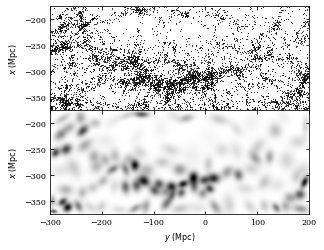

In [ ]:
"""
Mixture Model of SDSS Great Wall
--------------------------------
Figure 6.7
A two-dimensional mixture of 100 Gaussians (bottom) used to estimate the number
density distribution of galaxies within the SDSS Great Wall (top). Compare to
figures 6.3 and 6.4, where the density for the same distribution is computed
using both kernel density and nearest-neighbor-based estimates.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture
from astroML.datasets import fetch_great_wall
from astroML.utils.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# load great wall data
X = fetch_great_wall()


#------------------------------------------------------------
# Create a function which will save the results to a pickle file
#  for large number of clusters, computation will take a long time!
@pickle_results('great_wall_GMM.pkl')
def compute_GMM(n_clusters, max_iter=1000, tol=3, covariance_type='full'):
    clf = GaussianMixture(n_clusters, covariance_type=covariance_type,
                          max_iter=max_iter, tol=tol, random_state=0)
    clf.fit(X)
    print("converged:", clf.converged_)
    return clf

#------------------------------------------------------------
# Compute a grid on which to evaluate the result
Nx = 100
Ny = 250
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

#------------------------------------------------------------
# Compute the results
#
# we'll use 100 clusters.  In practice, one should cross-validate
# with AIC and BIC to settle on the correct number of clusters.
clf = compute_GMM(n_clusters=100)
log_dens = clf.score_samples(Xgrid).reshape(Ny, Nx)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0, left=0.08, right=0.95, bottom=0.13, top=0.9)

ax = fig.add_subplot(211, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)

ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.ylabel(r'$x\ {\rm (Mpc)}$')

ax = fig.add_subplot(212, aspect='equal')
ax.imshow(np.exp(log_dens.T), origin='lower', cmap=plt.cm.binary,
          extent=[ymin, ymax, xmin, xmax])
ax.set_xlabel(r'$y\ {\rm (Mpc)}$')
ax.set_ylabel(r'$x\ {\rm (Mpc)}$')

plt.show()

Figure  illustrates this point with the SDSS “Great Wall” data where we fit 100 Gaussians to the point distribution. While the underlying density representation is consistent with the distribution of galaxies and the positions of the Gaussians themselves correlate with the structure, there is not a one-to-one mapping between the Gaussians and the positions of clusters within the data. For these reasons, mixture models are often more appropriate when used as a density estimator as opposed
to cluster identification. See: https://academic.oup.com/mnrasl/article/427/1/L6/1003171

BIC is a good tool to find how many statistically significant clusters are
supported by the data. However, when density estimation is the only goal of the
analysis (i.e., when individual components or clusters are not assigned any specific
meaning) we can use any number of mixture components (e.g., when underlying
density is very complex and hard to describe using a small number of Gaussian
components). With a sufficiently large number of components, mixture models
approach the flexibility of nonparametric density estimation methods.

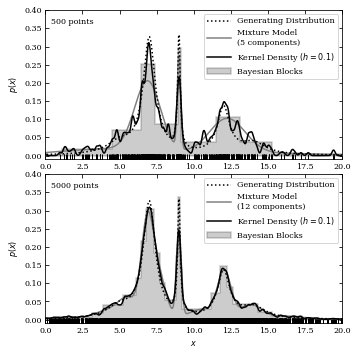

In [ ]:
"""
Comparison of 1D Density Estimators
-----------------------------------
Figure 6.8
A comparison of different density estimation methods for two simulated
one-dimensional data sets (same as in figure 6.5). Density estimators are
Bayesian blocks (Section 5.7.2), KDE (Section 6.1.1), and a Gaussian mixture
model. In the latter, the optimal number of Gaussian components is chosen
using the BIC (eq. 5.35). In the top panel, GaussianMixture solution has
three components but one of the components has a very large width and
effectively acts as a nearly flat background.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from sklearn.neighbors import KernelDensity

from astropy.visualization import hist
from sklearn.mixture import GaussianMixture

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
#  this is the same data used in the Bayesian Blocks figure
random_state = np.random.RandomState(seed=0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N), random_state=random_state)
                    for (mu, gamma, f) in mu_gamma_f])
random_state.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (500, 5000)
subplots = (211, 212)
k_values = (10, 100)

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)

    # Compute density with KDE
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(xN[:, None])
    dens_kde = np.exp(kde.score_samples(t[:, None]))

    # Compute density via Gaussian Mixtures
    # we'll try several numbers of clusters
    n_components = np.arange(3, 16)
    gmms = [GaussianMixture(n_components=n).fit(xN.reshape(-1, 1)) for n in n_components]
    BICs = [gmm.bic(xN.reshape(-1, 1)) for gmm in gmms]
    i_min = np.argmin(BICs)
    t = np.linspace(-10, 30, 1000)
    logprob = gmms[i_min].score_samples(t.reshape(-1, 1))

    # plot the results
    ax.plot(t, true_pdf(t), ':', color='black', zorder=3,
            label="Generating Distribution")
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k', lw=1.5)
    hist(xN, bins='blocks', ax=ax, density=True, zorder=1,
         histtype='stepfilled', lw=1.5, color='k', alpha=0.2,
         label="Bayesian Blocks")
    ax.plot(t, np.exp(logprob), '-', color='gray',
            label="Mixture Model\n(%i components)" % n_components[i_min])
    ax.plot(t, dens_kde, '-', color='black', zorder=3,
            label="Kernel Density $(h=0.1)$")

    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right')

    if subplot == 212:
        ax.set_xlabel('$x$')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)

plt.show()

## Determining the number of components
Most mixture methods require that we specify the number of components as an input to the method. For those methods which are based on a score or error, determination of the number of components can be treated as a model selection problem like any other, and thus be performed via cross-validation (as we did when finding optimal kernel bandwidth), or using BIC/AIC
criteria). The hierarchical clustering method  addresses this problem by finding clusterings at all possible scales.

It should be noted, however, that specifying the number of components (or clusters) is a relatively poorly posed question in astronomy. It is rare, despite the examples given in many machine learning texts, to find distinct, isolated and Gaussian clusters of data in an astronomical distribution. Almost all distributions are continuous. The number of clusters (and their positions) relates more to how well we can characterize the underlying density distribution. For clustering studies, it may be useful to fit a mixture model with many components and to divide components into
“clusters” and “background” by setting a density threshold.

An additional important factor that influences the number of mixture components supported by data is the sample size. The next figure illustrates how the best-fit GMM changes dramatically as the sample size is increased from 100 to 1000. Furthermore, even when the sample includes as many as 10,000 points, the underlying model is not fully recovered (only one of the two background components is recognized).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide


100 points convergence: [True, True, True, True, True, True, True]
1000 points convergence: [True, True, True, True, True, True, True]
10000 points convergence: [True, True, True, True, True, True, True]


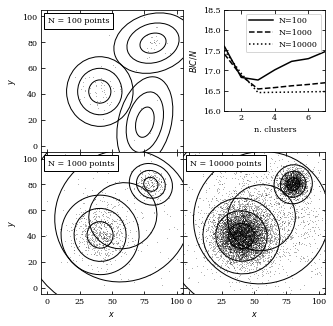

In [ ]:
"""
Number of Clusters for Gaussian Mixtures
----------------------------------------
Figure 6.9
The BIC-optimized number of components in a Gaussian mixture model as a
function of the sample size. All three samples (with 100, 1000, and 10,000
points) are drawn from the same distribution: two narrow foreground Gaussians
and two wide background Gaussians. The top-right panel shows the BIC as a
function of the number of components in the mixture. The remaining panels show
the distribution of points in the sample and the 1, 2, and 3 standard deviation
contours of the best-fit mixture model.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from astroML.utils import convert_2D_cov
from astroML.plotting.tools import draw_ellipse

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Set up the dataset
#  We'll use scikit-learn's Gaussian Mixture Model to sample
#  data from a mixture of Gaussians.  The usual way of using
#  this involves fitting the mixture to data: we'll see that
#  below.  Here we'll set the internal means, covariances,
#  and weights by-hand.

# we'll define clusters as (mu, sigma1, sigma2, alpha, frac)
clusters = [((50, 50), 20, 20, 0, 0.1),
            ((40, 40), 10, 10, np.pi / 6, 0.6),
            ((80, 80), 5, 5, np.pi / 3, 0.2),
            ((60, 60), 30, 30, 0, 0.1)]

gmm_input = GaussianMixture(len(clusters), covariance_type='full')
gmm_input.means_ = np.array([c[0] for c in clusters])
gmm_input.covariances_ = np.array([convert_2D_cov(*c[1:4]) for c in clusters])
gmm_input.weights_ = np.array([c[4] for c in clusters])
gmm_input.weights_ /= gmm_input.weights_.sum()
gmm_input.precisions_cholesky_ = 1 / np.sqrt(gmm_input.covariances_)
gmm_input.fit = None

#------------------------------------------------------------
# Compute and plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.11, right=0.9, bottom=0.11, top=0.9,
                    hspace=0, wspace=0)
ax_list = [fig.add_subplot(s) for s in [221, 223, 224]]
ax_list.append(fig.add_axes([0.62, 0.62, 0.28, 0.28]))

linestyles = ['-', '--', ':']

grid = np.linspace(-5, 105, 70)
Xgrid = np.array(np.meshgrid(grid, grid))
Xgrid = Xgrid.reshape(2, -1).T

Nclusters = np.arange(1, 8)
for Npts, ax, ls in zip([100, 1000, 10000], ax_list, linestyles):
    np.random.seed(1)
    X = gmm_input.sample(Npts)[0]

    # find best number of clusters via BIC
    clfs = [GaussianMixture(N, max_iter=500).fit(X)
            for N in Nclusters]
    BICs = np.array([clf.bic(X) for clf in clfs])
    print("{0} points convergence:".format(Npts),
          [clf.converged_ for clf in clfs])

    # plot the BIC
    ax_list[3].plot(Nclusters, BICs / Npts, ls, c='k',
                    label="N=%i" % Npts)

    clf = clfs[np.argmin(BICs)]
    log_dens = clf.score_samples(Xgrid).reshape((70, 70))

    # scatter the points
    ax.plot(X[:, 0], X[:, 1], ',k', alpha=0.3, zorder=1)

    # plot the components
    for i in range(clf.n_components):
        mean = clf.means_[i]
        cov = clf.covariances_[i]
        if cov.ndim == 1:
            cov = np.diag(cov)
        draw_ellipse(mean, cov, ax=ax, fc='none', ec='k', zorder=2)

    # label the plot
    ax.text(0.05, 0.95, "N = %i points" % Npts,
            ha='left', va='top', transform=ax.transAxes,
            bbox=dict(fc='w', ec='k'))

    ax.set_xlim(-5, 105)
    ax.set_ylim(-5, 105)


ax_list[0].xaxis.set_major_formatter(plt.NullFormatter())
ax_list[2].yaxis.set_major_formatter(plt.NullFormatter())

for i in (0, 1):
    ax_list[i].set_ylabel('$y$')

for j in (1, 2):
    ax_list[j].set_xlabel('$x$')

ax_list[-1].legend(loc=1)

ax_list[-1].set_xlabel('n. clusters')
ax_list[-1].set_ylabel('$BIC / N$')
ax_list[-1].set_ylim(16, 18.5)

plt.show()

# Cloning Data in D > 1 Dimensions
Here we return briefly to cloning a distribution of data, but cloning an arbitrary higher-dimensional distribution requires an estimate of the local density at each point. Gaussian mixtures are a natural choice for this, because they can flexibly model density fields in any number of dimensions, and easily generate
new points within the model.

In [ ]:
"""
Cloning a Distribution with Gaussian Mixtures
---------------------------------------------
Figure 6.10
Cloning a two-dimensional distribution. The left panel shows 1000 observed
points. The center panel shows a ten-component Gaussian mixture model fit to
the data (two components dominate over other eight). The third panel shows
5000 points drawn from the model in the second panel.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Create our data: two overlapping gaussian clumps,
# in a uniform background
np.random.seed(1)
X = np.concatenate([np.random.normal(0, 1, (200, 2)),
                    np.random.normal(1, 1, (200, 2)),
                    np.random.normal(4, 1.5, (400, 2)),
                    9 - 12 * np.random.random((200, 2))])

#------------------------------------------------------------
# Use a GaussianMixture to model the density and clone the points
gmm = GaussianMixture(5, 'full').fit(X)
X_new = gmm.sample(5000)[0]

xmin = -3
xmax = 9
Xgrid = np.meshgrid(np.linspace(xmin, xmax, 50),
                    np.linspace(xmin, xmax, 50))
Xgrid = np.array(Xgrid).reshape(2, -1).T

dens = np.exp(gmm.score_samples(Xgrid)).reshape((50, 50))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 2))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.05,
                    bottom=0.12, top=0.9)

# first plot the input
ax = fig.add_subplot(131, aspect='equal')
ax.plot(X[:, 0], X[:, 1], '.k', ms=2)

ax.set_title("Input Distribution")
ax.set_ylabel('$y$')

# next plot the gmm fit
ax = fig.add_subplot(132, aspect='equal')
ax.imshow(dens.T, origin='lower', extent=[xmin, xmax, xmin, xmax],
          cmap=plt.cm.binary)

ax.set_title("Density Model")
ax.yaxis.set_major_formatter(plt.NullFormatter())

# next plot the cloned distribution
ax = fig.add_subplot(133, aspect='equal')
ax.plot(X_new[:, 0], X_new[:, 1], '.k', alpha=0.3, ms=2)

ax.set_title("Cloned Distribution")
ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in fig.axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    ax.set_xlabel('$x$')

plt.show()

TypeError: ignored

In [ ]:
!pip install astroML

     |████████████████████████████████| 134 kB 18.6 MB/s 
